In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [201]:
# read in data
thievery = pd.read_csv("stolen_art_new.csv")
thievery

,title,maker,crimeCategory,primaryMaterial,numMaterials,period,size,units
0,Shakti II,Benjamin Creme,print,lithograph,1,21st century,4.227396,square feet
1,Seated Woman,Raphael Soyer,drawing-watercolour,other,2,other,4.276389,square feet
2,Magda and Raymond,Walter Pach,paintings,oil,2,20th century,3.334000,square feet
3,Jan,Edna Hibel,print,lithograph,1,20th century,NaN,NaN
4,Tiger painting,Michael Ward,paintings,watercolor,1,20th century,18.335000,square feet
...,...,...,...,...,...,...,...,...
995,Kanggye in North Korea,Hiyoshi Mamoru,print,wood,1,19th century,1.930500,square feet
996,Vineyard Haven Harbor Winter,Max Moran,paintings,oil,2,19th century,0.972111,square feet
997,Cheetah,Henry Mitchel,sculpture,bronze,1,other,3.000000,square feet
998,Two Whale Bone Busk Carvings,NaN,sculpture,other,1,19th century,1.000000,square feet


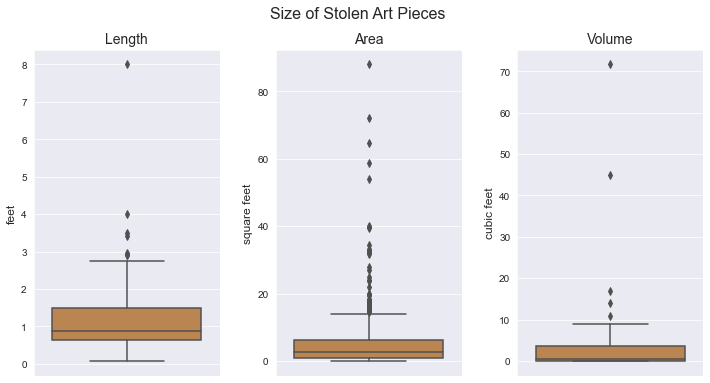

In [213]:
# distribution of size of pieces for each dimension
sns.set_style("darkgrid")

# create three subplots, one for each dimension
fig, axes = plt.subplots(1,3)
fig.set(figwidth=12, figheight=6)


sns.boxplot(data=thievery[thievery['units'] == "feet"], y='size', ax=axes[0], color="peru")
sns.boxplot(data=thievery[thievery['units'] == "square feet"], y='size', ax=axes[1], color="peru")
sns.boxplot(data=thievery[thievery['units'] == "cubic feet"], y='size', ax=axes[2], color="peru")

# set titles of axes
fig.suptitle('Size of Stolen Art Pieces', fontsize='16')
axes[0].set_title('Length', fontsize='14')
axes[1].set_title('Area', fontsize='14')
axes[2].set_title('Volume', fontsize='14')
axes[0].set_ylabel('feet', fontsize='12')
axes[1].set_ylabel('square feet', fontsize='12')
axes[2].set_ylabel('cubic feet', fontsize='12')

# put more horizontal space between plots
fig.subplots_adjust(wspace=0.3)
plt.show()

# deal with outliers - fill, etc.

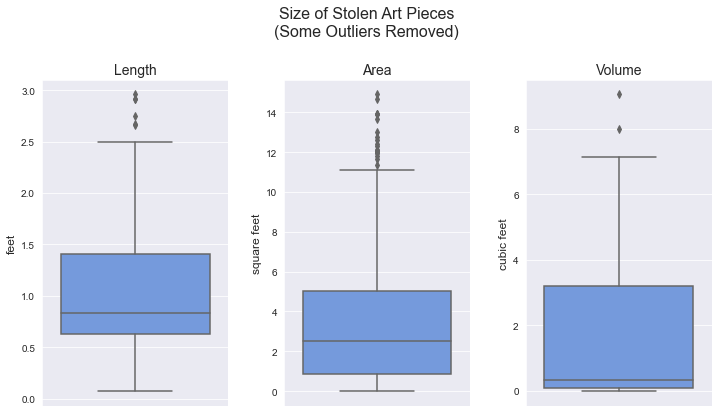

In [198]:
# Distribution of size of pieces
sns.set_style("darkgrid")

# Create two subplots for the regression and lowess lines
fig, axes = plt.subplots(1,3)
fig.set(figwidth=12, figheight=6)

# first plot: lm; second plot: lowess
# made it a different shade of blue because why not haha
sns.boxplot(data=thievery[(thievery['units'] == "feet") & (thievery['size'] < 3)], y='size', ax=axes[0], color="cornflowerblue")
sns.boxplot(data=thievery[(thievery['units'] == "square feet") & (thievery['size'] < 15)], y='size', ax=axes[1], color="cornflowerblue")
sns.boxplot(data=thievery[(thievery['units'] == "cubic feet") & (thievery['size'] < 10)], y='size', ax=axes[2], color="cornflowerblue")

# set titles of axes
fig.suptitle('Size of Stolen Art Pieces\n(Some Outliers Removed)', fontsize='16', y=1.05)
axes[0].set_title('Length', fontsize='14')
axes[1].set_title('Area', fontsize='14')
axes[2].set_title('Volume', fontsize='14')
axes[0].set_ylabel('feet', fontsize='12')
axes[1].set_ylabel('square feet', fontsize='12')
axes[2].set_ylabel('cubic feet', fontsize='12')

# put more horizontal space between plots
fig.subplots_adjust(wspace=0.3)
plt.show()

# deal with outliers - fill, etc.

In [203]:
outliers = thievery[((thievery['units'] == 'feet') & (thievery['size'] > 3)) | ((thievery['units'] == 'square feet') & (thievery['size'] > 15)) | ((thievery['units'] == 'cubic feet') & (thievery['size'] > 10))].sort_values(by=['units','size'])
outliers.to_markdown()

"|     | title                                                                                   | maker                                | crimeCategory       | primaryMaterial   |   numMaterials | period       |    size | units       |\n|----:|:----------------------------------------------------------------------------------------|:-------------------------------------|:--------------------|:------------------|---------------:|:-------------|--------:|:------------|\n| 785 | Apex, 1988                                                                              | John Okulick                         | paintings           | other             |              2 | 20th century | 10.8379 | cubic feet  |\n| 314 | Coming Through the Rye                                                                  | Frederic Remington                   | sculpture           | bronze            |              1 | other        | 13.9571 | cubic feet  |\n| 290 | Dogwood                                        

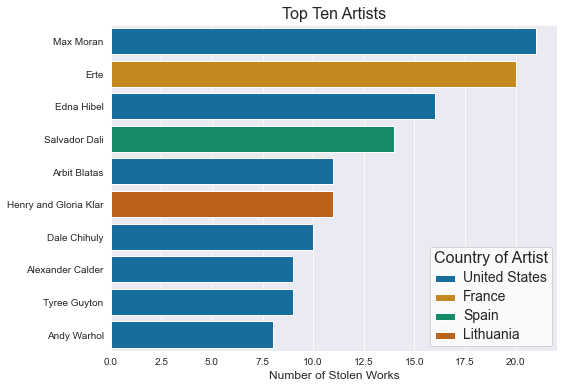

In [214]:
sns.set_style("darkgrid")
sns.set_palette("colorblind")
plt.figure(figsize=(8,6))

artists = ['Max Moran', 'Erte', 'Edna Hibel', 'Salvador Dali', 'Henry and Gloria Klar', 'Arbit Blatas', 'Dale Chihuly', 'Tyree Guyton', 'Alexander Calder', 'Andy Warhol']
top_artists = thievery[thievery['maker'].isin(artists)]['maker'].value_counts().to_frame().reset_index()
top_artists['country'] = ['United States', 'France', 'United States', 'Spain', 'United States', 'Lithuania', 'United States', 'United States', 'United States', 'United States']

ax = sns.barplot(y = 'index', x = 'maker', hue='country', data=top_artists, dodge=False)
ax.set_ylabel("")
ax.set_xlabel("Number of Stolen Works", fontsize='12')
ax.set_title("Top Ten Artists", fontsize='16')
legend = plt.legend(title='Country of Artist')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
legend.get_frame().set_facecolor('white')
plt.show()
